In [1]:
import numpy as np
import pickle
import pulse2percept as p2p

import skimage.io as sio
import skimage.color as sic
import skimage.transform as sit

import matplotlib.pyplot as plt
%matplotlib inline

Call to deprecated function __init__.
Call to deprecated function mov2npy.
Call to deprecated function micron2deg. Use p2p.retina.ret2dva instead.
Call to deprecated function deg2micron. Use p2p.retina.dva2ret instead.
Call to deprecated function savemoviefiles. Use p2p.files.save_video instead.
Call to deprecated function npy2movie. Use p2p.files.save_video instead.
Call to deprecated function scale. Use p2p.stimuli.image2pulsetrain instead.
Call to deprecated function Movie2Pulsetrain. Use p2p.stimuli.video2pulsetrain instead.
Call to deprecated function retinalmovie2electrodtimeseries.


In [2]:
# Place an Argus I array on the retina
argus = p2p.implants.ArgusII(x_center=0, y_center=0, h=50, rot=0*np.pi/180)

In [13]:
stim = p2p.stimuli.image2pulsetrain('letters/A.jpg', argus,
                                    coding='frequency', max_contrast=True,
                                    rftype='square', rfsize=525.0,
                                    invert=True, dur=0.1)

2017-03-22 16:50:21,695 [pulse2percept.stimuli] [INFO] Loaded file 'letters/A.jpg'.
2017-03-22 16:50:21,700 [pulse2percept.stimuli] [INFO] Image resized to 21x37 pixels.


In [3]:
overwrite = True
imgpath = './letters/'
imgfiles = [
#     'A.jpg',
    'I.jpg'
]

In [4]:
sim = p2p.Simulation(argus)

# Set parameters of the optic fiber layer (OFL)
# In previous versions of the model, this used to be called the `Retina`
# object, which created a spatial grid and generated the axtron streak map.
sampling = 50       # spatial sampling of the retina (microns)
axon_lambda = 2        # constant that determines fall-off with axonal distance
sim.set_optic_fiber_layer(sampling=sampling, axon_lambda=axon_lambda,
                          x_range=[-2800, 2800], y_range=[-1700, 1700])

In [5]:
e_rf = []
for e in argus:
    e_rf.append(e.receptive_field(sim.ofl.gridx, sim.ofl.gridy, rftype='square', size=525.0))

In [6]:
img = sio.imread(imgpath + imgfiles[0], as_grey=True)
img.min(), img.max(), img.dtype

(0, 255, dtype('uint8'))

In [7]:
img.shape

(200, 256)

In [8]:
newsmall = sit.resize(img, sim.ofl.gridx.shape)
newsmall.min(), newsmall.max(), newsmall.dtype, newsmall.shape

(0.0, 1.0, dtype('float64'), (69, 113))

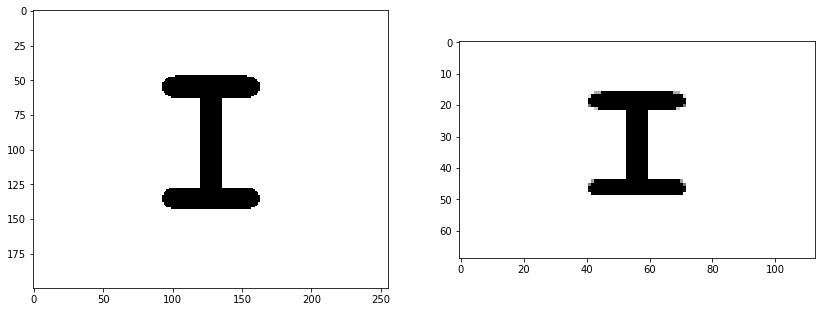

In [9]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(newsmall, cmap='gray')

In [10]:
data = newsmall[..., np.newaxis]
data = np.concatenate((data, data), axis=-1)
data.shape

(69, 113, 2)

In [11]:
pt = []
for rf in e_rf:
    rflum = p2p.stimuli.retinalmovie2electrodtimeseries(rf, data)
    ptrain = p2p.stimuli.Movie2Pulsetrain(rflum, tsample=0.005/1000)
    pt.append(ptrain)

In [12]:
for file in imgfiles:
    for invert in [True, False]:
        if invert:
            stimfile = 'stim-%s-amplitude-sampling%d-invert-old.dat' % (file[:-4], sampling)
        else:
            stimfile = 'stim-%s-amplitude-sampling%d-old.dat' % (file[:-4], sampling)

        try:
            if overwrite:
                raise FileNotFoundError('Force overwrite')
            pickle.load(open(stimfile, 'rb'))
            print('File %s already exists, skip' % stimfile)
        except:
            print('Processing file %s' % stimfile)
            img = sio.imread(imgpath + imgfiles[0], as_grey=True)
            newsmall = sit.resize(img, sim.ofl.gridx.shape)
            
            if invert:
                newsmall = 1.0 - newsmall

            insave = 'in-%s.jpg' % stimfile[5:-4]
            sio.imsave(insave, newsmall)
            print('Created file %s' % insave)
            
            data = newsmall[..., np.newaxis]
            data = np.concatenate((data, data), axis=-1)

            stim = []
            for rf in e_rf:
                rflum = p2p.stimuli.retinalmovie2electrodtimeseries(rf, data)
                ptrain = p2p.stimuli.Movie2Pulsetrain(rflum, tsample=0.005/1000)
                pptrain = p2p.utils.TimeSeries(ptrain.tsample, ptrain.data)
                stim.append(pptrain)

            pickle.dump(stim, open(stimfile, "wb"))
            print('Created file %s' % stimfile)

Processing file stim-I-amplitude-sampling50-invert-old.dat
Created file in-I-amplitude-sampling50-invert-old.jpg
Created file stim-I-amplitude-sampling50-invert-old.dat
Processing file stim-I-amplitude-sampling50-old.dat
Created file in-I-amplitude-sampling50-old.jpg
Created file stim-I-amplitude-sampling50-old.dat


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
